In [15]:
import os
import urllib
import urllib.request
import cv2
import mlflow

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mlflow

from zipfile import ZipFile
import sys
# sys.path.append(r'../src')
import importlib

import model
import layers
import activations

from utils import one_hot_encode_index
from optimizers import Adam
from activations import Softmax, ReLU
from layers import Dropout, LinearLayer, ConvolutionLayer, PoolingLayer, FlattenLayer
from loss import CategoricalCrossEntropyLoss

def nsgpmnet_reloads():

    importlib.reload(model)
    importlib.reload(layers)
    importlib.reload(activations)

nsgpmnet_reloads()

### Loading MNIST-fashion-data:

In [16]:
# Loads a MNIST dataset
def load_mnist_dataset(dataset, path):
    # Scan all the directories and create a list of labels
    labels = os.listdir(os.path.join(path, dataset))
    # Create lists for samples and labels
    X = []
    y = []
    # For each label folder
    for label in labels:
        # And for each image in given folder
        for file in os.listdir(os.path.join(path, dataset, label)):
            # Read the image
            image = cv2.imread(os.path.join(path, dataset, label, file), cv2.IMREAD_UNCHANGED)
            # And append it and a label to the lists
            X.append(image)
            y.append(label)
    # Convert the data to proper numpy arrays and return
    return np.array(X), np.array(y).astype('uint8')


def create_data_mnist(path):
    # Load both sets separately
    X, y = load_mnist_dataset('train', path)
    X_test, y_test = load_mnist_dataset('test', path)
    y = one_hot_encode_index(y, 10)
    y_test = one_hot_encode_index(y_test, 10)
    
    # And return all the data
    return X, y, X_test, y_test

In [17]:
path0 = '/Users/petermagnusson/Documents/data/courses to study/malmö universitet/3 ht2021/120p 2yrs MSc copmuter science - applied data science/course AI for data science/project/leaf/data/fashion_mnist_images'

X, y, X_test, y_test = create_data_mnist(path0)

y_flat = y.copy()

### Handy print fuction:

In [18]:
def print_info(a):
    print('shapes for inputs and outputs:')
    print(a.shape)
    print('(min, max) for inputs and outputs:')
    print(np.min(a), np.max(a))

### Shuffle Training data - on initial loaded data:

In [19]:
keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)
X = X[keys]
y = y[keys]
y_flat = y_flat[keys]

### Reshaping data for cnn-model: 

In [20]:
def add_channles(v):
    return np.expand_dims(v, axis=1)

X_chns = add_channles(X)
X_chns_test = add_channles(X_test)

# Optional truncation to fewer images for integration and timing testing.
tval = 59904 # 200, 59968 (for batch_size=64), 59904 (for batch_size=128) 9984, 1024, 2048
X_chns = X_chns[:tval, :, :]
X_chns_test = X_chns_test[:tval, :, :]

# print_info(X)
# print_info(X_chns)
# print_info(X_chns_test)

### Scaling between -1 and 1 - cnn-model

In [21]:
def scale_img(v):
    return (v - 127.5) /127.5

X_chns = scale_img(X_chns)
X_chns_test = scale_img(X_chns_test)

### Shuffle Training data - cnn-model - after truncation:

In [ ]:
keys = np.array(range(X_chns.shape[0]))
np.random.shuffle(keys)
X_chns = X_chns[keys]
y = y[keys]

### Create a reduced cnn-model sequence:

In [22]:
cce_loss = CategoricalCrossEntropyLoss()
optimizer = Adam(decay=5e-5)
my_model = model.Model(optimizer, cce_loss)

my_model.set_sequence([
                ConvolutionLayer(1, 1, 3),
                FlattenLayer(),
                LinearLayer(676, 128),
                ReLU(),
                Dropout(0.5),
                LinearLayer(128, 128),
                ReLU(),
                LinearLayer(128, 10),
                Softmax()
            ])

# Setting the model save path:
path1 = '/Users/petermagnusson/VisualStudioCodeProjects/saved_models/model1'
my_model.set_save_config(model_name='cnn_9_0', save_path=path1)

In [ ]:
print_info(X)
print_info(X_chns)

### Train with the reduced cnn-model, optional monitoring with MLflow:

In [23]:
import time

mlflow.set_experiment(experiment_name='MNIST Fashion reduced conv')

t0 = time.time()

# my_model.train(X_chns, y, epochs=1, batch_size=8, log_freq=8, validation=(X_chns_test, y_test))
my_model.train(X_chns, y, epochs=10, batch_size=128, log_freq=100, validation=(X_chns_test, y_test))

t_d0 = time.time() - t0
print('Took {}'.format(t_d0))

# with mlflow.start_run():
#     my_model.train(X_chns, y, epochs=10, batch_size=128, log_freq=100, validation=(X_chns_test, y_test))

=== Epoch: 1 ===
Step: 0/468, accuracy0.109, loss2.385, learning rate 0.0010000 
Step: 100/468, accuracy0.688, loss0.850, learning rate 0.0009950 
Step: 200/468, accuracy0.648, loss0.929, learning rate 0.0009901 
Step: 300/468, accuracy0.781, loss0.817, learning rate 0.0009852 
Step: 400/468, accuracy0.781, loss0.635, learning rate 0.0009804 
Step: 467/468, accuracy0.781, loss0.650, learning rate 0.0009772 
Epoch: 1/10, accuracy0.668, loss1.041, learning rate 0.001
--Validation--
Validation : Accuracy: 0.818, Loss: 0.508
=== Epoch: 2 ===
Step: 0/468, accuracy0.812, loss0.639, learning rate 0.0009771 
Step: 100/468, accuracy0.805, loss0.534, learning rate 0.0009724 
Step: 200/468, accuracy0.797, loss0.635, learning rate 0.0009677 
Step: 300/468, accuracy0.703, loss0.875, learning rate 0.0009630 
Step: 400/468, accuracy0.805, loss0.586, learning rate 0.0009584 
Step: 467/468, accuracy0.797, loss0.602, learning rate 0.0009553 
Epoch: 2/10, accuracy0.793, loss0.591, learning rate 0.001
--V

### Validate the cnn-model with the test-set:

In [24]:
my_model.evaluate(X_chns_test, y_test, 128)

Validation : Accuracy: 0.863, Loss: 0.394


### Display

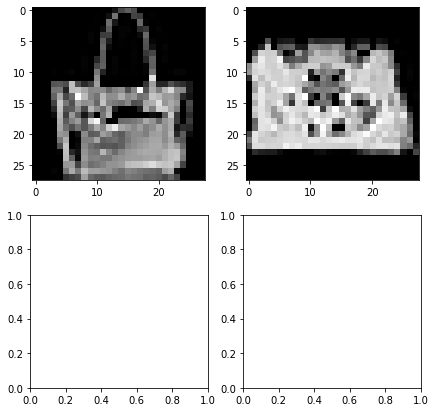

In [25]:
fig, ax = plt.subplots(figsize=(7.00, 7.00), ncols=2, nrows=2)
# fig, ax = plt.subplots()
# ax.imshow(c[0, 0, :, :], cmap=cm.gray)
ax[0, 0].imshow(X_chns[int(np.random.randint(0, 200)), 0, :, :], cmap=cm.gray)
ax[0, 1].imshow(X_chns[123, 0, :, :], cmap=cm.gray)
# ax[1, 0].imshow(pool1.dinputs[0, 0, :, :], cmap=cm.gray)
# ax[1, 1].imshow(conv1.outputs[0, 1, :, :], cmap=cm.gray)
plt.show()

### Retreive org. data and flatten for ffnn model:

In [26]:
def vectorize(v):
    return v.reshape(v.shape[0], -1)

X_flat = vectorize(X)
X_flat_test = vectorize(X_test)

# print_info(X)
# print_info(X_flat)

### Trucate for ffnn model:

In [ ]:
# Truncate to fewer images for integration and timing testing.
tval = 9984 # 200, 59968, 9984, 1024, 2048
X_flat = X_flat[:tval, :]
X_flat_test = X_flat_test[:tval, :]

### Scaling between -1 and 1 - ffnn model

In [27]:
def scale_img(v):
    return (v - 127.5) /127.5

X_flat = scale_img(X_flat)
X_flat_test = scale_img(X_flat_test)

### Shuffle training data - ffnn model:

In [ ]:
keys = np.array(range(X_flat.shape[0]))
np.random.shuffle(keys)
X_flat = X_flat[keys]
y_flat = y_flat[keys]

# print_info(X)
# print_info(X_flat)
# print_info(y_flat)

### Create a sequence for ffnn model:

In [29]:
cce_loss = CategoricalCrossEntropyLoss()
optimizer = Adam(decay=5e-5)

naive_model = model.Model(optimizer, cce_loss)

naive_model.set_sequence([
                LinearLayer(X_flat.shape[1], 128),
                ReLU(),
                Dropout(0.5),
                LinearLayer(128, 128),
                ReLU(),
                LinearLayer(128, 10),
                Softmax()
            ])

# Setting the model save path:
path1 = '/Users/petermagnusson/VisualStudioCodeProjects/saved_models/model0'
naive_model.set_save_config(model_name='ffnn_0', save_path=path1)

### Train with the ffnn model, optional monitoring with MLflow:

In [30]:
import time

mlflow.set_experiment(experiment_name='Naive Model')

t0 = time.time()

# naive_model.train(X_flat, y_flat, epochs=1, batch_size=8, log_freq=32, validation=(X_flat_test, y_test))
naive_model.train(X_flat, y_flat, epochs=10, batch_size=128, log_freq=100, validation=(X_flat_test, y_test))

t_d0 = time.time() - t0
print('Took {}'.format(t_d0))

# with mlflow.start_run():
#     naive_model.train(X_flat, y_flat, epochs=10, batch_size=128, log_freq=100, validation=(X_flat_test, y_test))


=== Epoch: 1 ===
Step: 0/469, accuracy0.086, loss3.606, learning rate 0.0010000 
Step: 100/469, accuracy0.750, loss0.704, learning rate 0.0009950 
Step: 200/469, accuracy0.758, loss0.575, learning rate 0.0009901 
Step: 300/469, accuracy0.781, loss0.550, learning rate 0.0009852 
Step: 400/469, accuracy0.781, loss0.538, learning rate 0.0009804 
Step: 468/469, accuracy0.771, loss0.604, learning rate 0.0009771 
Epoch: 1/10, accuracy0.743, loss0.713, learning rate 0.001
--Validation--
Validation : Accuracy: 0.826, Loss: 0.478
=== Epoch: 2 ===
Step: 0/469, accuracy0.789, loss0.516, learning rate 0.0009771 
Step: 100/469, accuracy0.812, loss0.483, learning rate 0.0009723 
Step: 200/469, accuracy0.789, loss0.468, learning rate 0.0009676 
Step: 300/469, accuracy0.789, loss0.532, learning rate 0.0009630 
Step: 400/469, accuracy0.820, loss0.421, learning rate 0.0009584 
Step: 468/469, accuracy0.792, loss0.592, learning rate 0.0009552 
Epoch: 2/10, accuracy0.814, loss0.515, learning rate 0.001
--V